In [149]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.tree as tree

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB, ComplementNB
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

import math
import random
from tqdm import tqdm, trange

import seaborn as sns

seed = 42

random.seed(seed)

In [150]:
# Load data
df = pd.read_csv('extracted_real_length.dataset')
features = df.columns[:8]
targets = df.target


# Set target for any example with target > 20, to 20
df.loc[df.target > 21] = 21


# Reduce size of each class to be uniform, matching the size of the minimum class (583)
M = [df.loc[df.target == i][:551] for i in range(1,21)]
df = pd.concat(M).reset_index()

len(df)

11020

In [151]:
# Normalize data and split into train/test sets
print(df)
df_without_targets = df.drop('target', axis=1)
x = df_without_targets.values
scaler = preprocessing.MinMaxScaler()
scaled_x = scaler.fit_transform(x)

targets = df.target
# df = pd.DataFrame(data=scaled_x, columns=df_without_targets.columns)
# df['target'] = targets

# X_train, X_test, Y_train, Y_test = train_test_split(df[features], targets, shuffle=True, random_state=seed)
# len(X_train), len(X_test)

       index  nodes  nodes_merged  distinct_features  functions  lambdas  \
0          0     63            25                 11         10        0   
1          2     15            10                  8          2        0   
2          5     39            20                 10          6        0   
3          6     15            12                  9          2        0   
4         10     39            20                 10          6        0   
...      ...    ...           ...                ...        ...      ...   
11015  49658    261            83                 27         49        1   
11016  49704    451           107                 28         72        5   
11017  49725    167            55                 20         28        2   
11018  49786    125            42                 18         21        1   
11019  49932    327            88                 27         50        4   

       applications  variables  constants  target  
0                10          6     

In [154]:
X_train, X_test = [], []
Y_train, Y_test = [], []
count = 0
current_var = 0
for i, (x, y) in enumerate(zip(scaled_x, df.target)):
    if y != current_var:
        current_var = y
        count = 0
        
    if count % 4 < 3:
        X_train.append(x)
        Y_train.append(y)
    else:
        X_test.append(x)
        Y_test.append(y)
        
    count += 1

In [123]:
len(Y_test)/20

137.0

In [124]:
sum((x for x in Y_test if x == 1)), 551 - 137

(137, 414)

In [155]:
accuracies = []
counts = []

for i in trange(2, 21):
    # Relabel data according to current split
    temp_Y_train = [0 if y < i else 1 for y in Y_train]
    temp_Y_test = [0 if y < i else 1 for y in Y_test]
    
    
    # Train decision tree on data
#     decision_tree = DecisionTreeClassifier(min_samples_split=20, max_depth=3, criterion='entropy', random_state=42)
#     decision_tree.fit(X_train, temp_Y_train)
#     preds = decision_tree.predict(X_test)

    nbc = svm.SVC()
# #     nbc = ComplementNB()
    nbc.fit(X_train, temp_Y_train)
    preds = nbc.predict(X_test)
    counts.append(sum(preds))
    
    acc = sum((preds == temp_Y_test))/len(temp_Y_test)
    accuracies.append(acc)

100%|██████████| 19/19 [00:26<00:00,  1.39s/it]


In [125]:
counter = dict()
for y in Y_train:
    if y in counter:
        counter[y] += 1
    else:
        counter[y] = 1
print(counter)

counter = dict()
for y in Y_test:
    if y in counter:
        counter[y] += 1
    else:
        counter[y] = 1
print(counter)

{1: 414, 2: 414, 3: 414, 4: 414, 5: 414, 6: 414, 7: 414, 8: 414, 9: 414, 10: 414, 11: 414, 12: 414, 13: 414, 14: 414, 15: 414, 16: 414, 17: 414, 18: 414, 19: 414, 20: 414}
{1: 137, 2: 137, 3: 137, 4: 137, 5: 137, 6: 137, 7: 137, 8: 137, 9: 137, 10: 137, 11: 137, 12: 137, 13: 137, 14: 137, 15: 137, 16: 137, 17: 137, 18: 137, 19: 137, 20: 137}


In [160]:
accuracies = []
counts = []

for i in trange(1, 20):
    # Relabel data according to current split
#     temp_Y_train = [0 if y < i else 1 for y in Y_train]
#     temp_Y_test = [0 if y < i else 1 for y in Y_test]
    
    temp_Y_train = Y_train[(i - 1)*414:(i+1)*414]
    temp_Y_test = Y_test[(i-1)*137:(i+1)*137]
    temp_X_train = X_train[(i - 1)*414:(i+1)*414]
    temp_X_test = X_test[(i-1)*137:(i+1)*137]
    
    # Train decision tree on data
    decision_tree = DecisionTreeClassifier(min_samples_split=20, max_depth=3, criterion='entropy', random_state=42)
    decision_tree.fit(temp_X_train, temp_Y_train)
    preds = decision_tree.predict(temp_X_test)

#     nbc = svm.SVC()
#     nbc = ComplementNB()
#     nbc.fit(temp_X_train, temp_Y_train)
#     preds = nbc.predict(temp_X_test)
    counts.append(sum(preds))
    acc = sum((preds == temp_Y_test))/len(temp_Y_test)
    accuracies.append(acc)

100%|██████████| 19/19 [00:00<00:00, 34.56it/s]


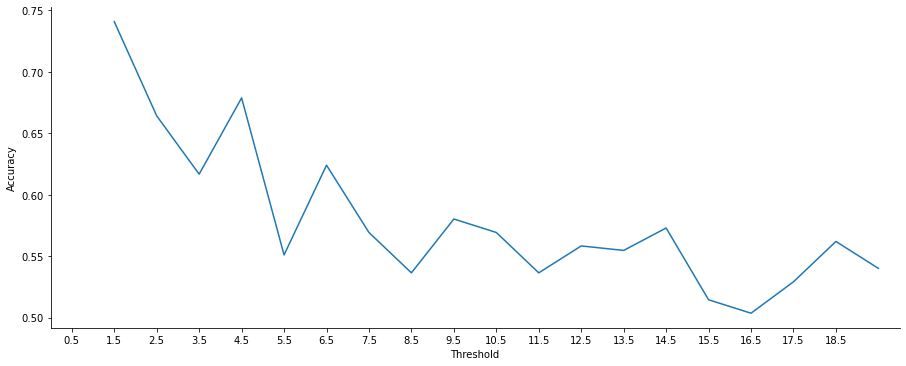

In [161]:
results_df = pd.DataFrame(data={'Threshold': [i+0.5 for i in range(1,20)], 'Accuracy': accuracies})
ax = sns.relplot(x="Threshold", y="Accuracy", kind="line", data=results_df, aspect=2.5)
ax.set(xlim=(0,20))
plt.xticks(np.arange(0.5, 19.5, 1.0))
plt.show()

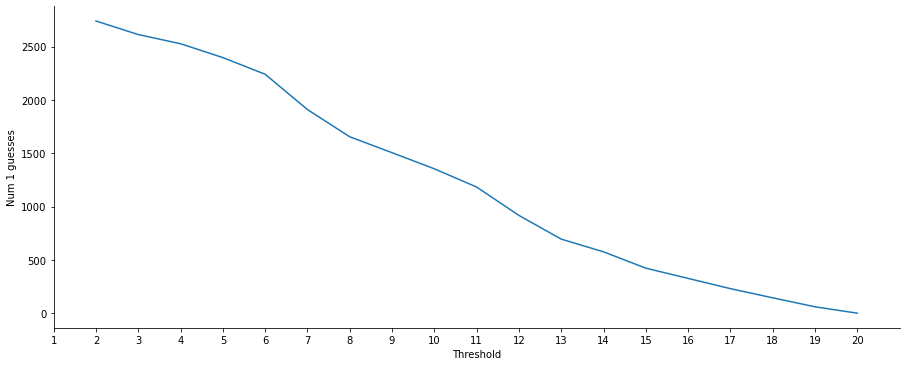

In [135]:
results_df = pd.DataFrame(data={'Threshold': [i for i in range(2,21)], 'Num 1 guesses': counts})
ax = sns.relplot(x="Threshold", y="Num 1 guesses", kind="line", data=results_df, aspect=2.5)
ax.set(xlim=(1,21))
plt.xticks(np.arange(1, 21, 1.0))
plt.show()